# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

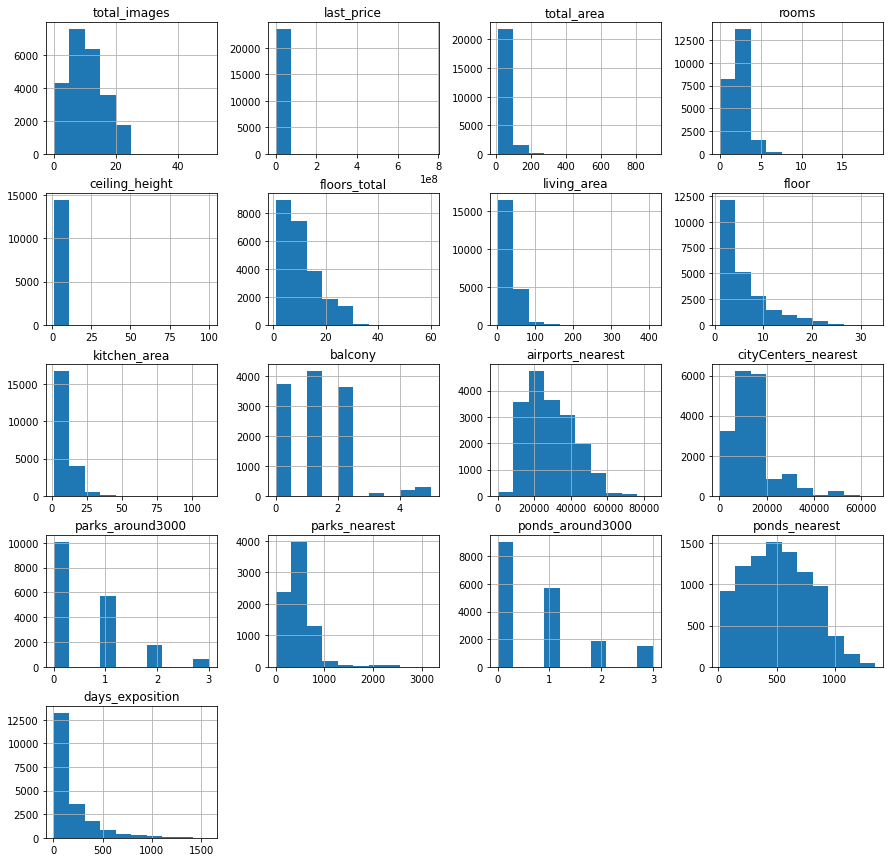

In [1]:
import pandas as pd

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
print(data.head(10))
data.info()
data.isnull().sum()
data.hist(figsize=(15, 15));

**Выводы**

Проблемы в данных, с которыми нужно разобраться:
1. Есть пропуски в данных
2. В некоторых колонках нужно првиести данные из одного типа в другой
3. В некоторых колонках нужно перевести данные изх метров в километры

### Предобработка данных

In [2]:
#сначала нужно заполнить пробелы в данных

data = data.dropna(subset=['locality_name', 'floors_total']) #В названии населённого пункта и всего этажей в доме пропуски удалим, т.к. заменить их нечем + их не много, и удаление этих строк на общую картину не должно повлиять
#дальше меняем пропуски на значения

#высота потолков - заменим на среднее значение
data['ceiling_height']= data['ceiling_height'].fillna(data['ceiling_height'].mean())


data['living_area']= data['living_area'].fillna(data['living_area'].median()) 
#т.к. разброс большой, то логичнее применить медианное значение к замене пропусков. Среднее может сильно исказить данные 



data['is_apartment']= data['is_apartment'].fillna(0) # все пропуски заменим на True (0) т.к. фонд в основном жилой.
data['is_apartment'] = data['is_apartment'].map({True: 1, False: 0}) 
#заодно приведём к числовому типу, чтобы проще было считать если необходимо


data['kitchen_area']= data['kitchen_area'].fillna(data['kitchen_area'].median())
#площадь кухни тоже имеет смысл заполнить пропуски медианой, по тойже причине что и в жилой площади


data['balcony']= data['balcony'].fillna(0)
#балконы поставим везде на месте пропусков 0, т.к. раз не указан, т оскорее всего балконов и нет


data['cityCenters_nearest']= data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())
#растояние до центра города заполним медианой, т.к. среднее может исказить данные из-за слишком далёких и квартир расположенных в центре.


data['parks_around3000']= data['parks_around3000'].fillna(0)
#заменим пропуски на 0, т.к. возможно пропуски означают, что в радиусе 3 км нет парков, т.е. 0

data['parks_nearest']= data['parks_nearest'].fillna(data['parks_nearest'].median())
#растояние до ближайшего парка заменим на медианное, т.к. на среднее могут повлиять квартиры расположенные слишком далеко или слишком близко о тпарка 


data['ponds_around3000']= data['ponds_around3000'].fillna(0)
#пропуски заменим на 0, т.к. они могут означать что водоёмов нет


data['ponds_nearest']= data['ponds_nearest'].fillna(data['ponds_nearest'].median())
#заменяем пропуски медианой по логике с растоянием до ближайшего парка

data['days_exposition']= data['days_exposition'].fillna(data['days_exposition'].median())
#заменим на медиану, чтобы исключить неточность данных из-за слишком короткизх или долгих объявлений


data['airports_nearest']= data['airports_nearest'].fillna(data['airports_nearest'].median())
#растояние до ближайшего аэропорта берём медиану из соображений, что слишком далёкте или слишком близкие квартиры могут исказить данные

#снова проверяем остались ли пропуски
data.isnull().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

In [3]:
# теперь необходимо изменить тип данных в тех колонках, где это необходимо
#для начала данные в first-day-exposition из формата object переведём в тип data
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#print(data['first_day_exposition'])

#переводим кол-во этажей в int
data['floors_total'] = data['floors_total'].astype('int')

data['floor'] = data['floor'].astype('int')

# тоже делаем с balcony
data['balcony'] = data['balcony'].astype('int')

# тоже делаем с parks_around3000
data['parks_around3000'] = data['parks_around3000'].astype('int')

# тоже делаем с ponds_around3000
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
# тоже делаем с days_exposition
data['days_exposition'] = data['days_exposition'].astype('int')
# переведём в тип int столбец `last_price`
data['last_price'] = data['last_price'].astype('int')
#проверяем поменялись ли типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  int64         
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

In [4]:
# переводим метры в километры
data['airports_nearest'] = data['airports_nearest'] / 1000
data['cityCenters_nearest'] = data['cityCenters_nearest'] / 1000
data['parks_nearest'] = data['parks_nearest'] / 1000
data['ponds_nearest'] = data['ponds_nearest'] / 1000

#округление
data['airports_nearest'] = data['airports_nearest'].astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int')
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['parks_nearest'] = data['parks_nearest'].astype('int')

#првоеряем данные
print(data['airports_nearest'].head())
print(data['cityCenters_nearest'].head())
print(data['parks_nearest'].head())
print(data['ponds_nearest'].head())

0    18
1    12
2    21
3    28
4    31
Name: airports_nearest, dtype: int64
0    16
1    18
2    13
3     6
4     8
Name: cityCenters_nearest, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: parks_nearest, dtype: int64
0    0.755
1    0.503
2    0.574
3    0.234
4    0.048
Name: ponds_nearest, dtype: float64


In [5]:
#теперь нужно устранить дубликаты в названиях населённых пунктов
# сначала посмотрим какие названия есть вообще
data['locality_name'].unique().tolist()
# некоторые названяи имеются такой вид:поселок Гарболово и деревня Гарболово - менять их нет смысла, т.к. это могут быть разные населённые пункты
#поэтому менять ничего здесь не будем, явных дубликатов не наблюдается. Можно поменять только регистр: заглвные буквы сделать строчными
data['locality_name'] = data['locality_name'].str.lower()
#заодно моджно все "ё" заменить на "е" для единообразия
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
#ещё раз проверяем
data['locality_name'].unique().tolist()

['санкт-петербург',
 'поселок шушары',
 'городской поселок янино-1',
 'поселок парголово',
 'поселок мурино',
 'ломоносов',
 'сертолово',
 'петергоф',
 'пушкин',
 'деревня кудрово',
 'коммунар',
 'колпино',
 'поселок городского типа красный бор',
 'гатчина',
 'деревня федоровское',
 'выборг',
 'кронштадт',
 'кировск',
 'деревня новое девяткино',
 'поселок металлострой',
 'поселок городского типа лебяжье',
 'поселок городского типа сиверский',
 'поселок молодцово',
 'поселок городского типа кузьмоловский',
 'садовое товарищество новая ропша',
 'павловск',
 'деревня пикколово',
 'всеволожск',
 'волхов',
 'кингисепп',
 'приозерск',
 'сестрорецк',
 'деревня куттузи',
 'поселок аннино',
 'поселок городского типа ефимовский',
 'поселок плодовое',
 'деревня заклинье',
 'поселок торковичи',
 'поселок первомайское',
 'красное село',
 'поселок понтонный',
 'сясьстрой',
 'деревня старая',
 'деревня лесколово',
 'поселок новый свет',
 'сланцы',
 'село путилово',
 'ивангород',
 'мурино',
 'шлиссель

In [6]:
#попробуем поискать аномалии
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771283,10.675875,34.102255,5.878124,0.002122,10.423234,0.593677,27.746955,13.533673,0.468831,0.020921,0.589900,0.508863,169.203692
std,5.681156,1.091093e+07,35.657060,1.078591,0.989266,6.594823,21.189133,4.871485,0.046015,5.631746,0.960660,11.100493,7.549740,0.748403,0.175851,0.883966,0.172307,206.497729
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,0.000000,7.300000,0.000000,21.000000,10.000000,0.000000,0.000000,0.000000,0.503000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.771283,9.000000,30.000000,4.000000,0.000000,9.100000,0.000000,26.000000,13.000000,0.000000,0.000000,0.000000,0.503000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.771283,16.000000,41.100000,8.000000,0.000000,11.410000,1.000000,34.000000,15.000000,1.000000,0.000000,1.000000,0.503000,198.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,1.000000,112.000000,5.000000,84.000000,65.000000,3.000000,3.000000,3.000000,1.344000,1580.000000


In [7]:
# есть аномалии и их надо устранить
# функция отсекающая аномальные значения.
def anomali(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    dfq = df.loc[(df[column] < q3 + 1.5*iqr) & (df[column] > q1 - 1.5*iqr), column]
    return dfq
# столбцы где присутствуют анмоальные значения, и которые надо убрать
list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms']
for col in list_features:
    data[col] = anomali(data, col)
    
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.151900e+04,22326.000000,23371.000000,22033.000000,23565.000000,22688.000000,23565.000000,23565.000000,22005.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,21228.000000
mean,9.878421,4.837115e+06,54.319704,2.030208,2.702974,10.675875,31.208433,5.878124,0.002122,9.310328,0.593677,27.746955,13.533673,0.468831,0.020921,0.589900,0.508863,112.794564
std,5.681156,2.215774e+06,19.331030,0.973563,0.130320,6.594823,13.035528,4.871485,0.046015,2.754380,0.960660,11.100493,7.549740,0.748403,0.175851,0.883966,0.172307,96.371987
min,0.000000,1.219000e+04,12.000000,0.000000,2.400000,1.000000,2.000000,1.000000,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013000,1.000000
25%,6.000000,3.300000e+06,39.400000,1.000000,2.600000,5.000000,19.000000,2.000000,0.000000,7.100000,0.000000,21.000000,10.000000,0.000000,0.000000,0.000000,0.503000,45.000000
50%,9.000000,4.400000e+06,50.000000,2.000000,2.771283,9.000000,30.000000,4.000000,0.000000,9.100000,0.000000,26.000000,13.000000,0.000000,0.000000,0.000000,0.503000,95.000000
75%,14.000000,6.000000e+06,65.500000,3.000000,2.771283,16.000000,39.500000,8.000000,0.000000,10.900000,1.000000,34.000000,15.000000,1.000000,0.000000,1.000000,0.503000,146.000000
max,50.000000,1.186686e+07,114.200000,5.000000,3.020000,60.000000,74.200000,33.000000,1.000000,17.550000,5.000000,84.000000,65.000000,3.000000,3.000000,3.000000,1.344000,427.000000


In [8]:
# првоерим на явные дубликаты
data.duplicated().sum()

0

Явных дубликатов не обнаружено

**Выводы промежуточные**
1. Проведена работа с пропусками в данных, все пропуски обработаны
2. Все типы данных в колонках приведены к тем типам данных, с котороыми возможно дальше работать
3. Првоедена првоерка на дубликаты и аномальные значения - не обнаружено
4. Првоеренны данные на предмет аномалий + проведена работа с аномалиями на предмет их устранения

### Посчитайте и добавьте в таблицу новые столбцы

In [9]:
#добавим столбец и посчитаем цену одного квадратного метра
data['price_m2'] = data['last_price']/data['total_area']
data['price_m2']= data['price_m2'].fillna(data['price_m2'].median())
# выведем первые 5 строк, чтобы посмотреть получилось ли создать новую колонку и запсиать туда стоимость квадратного метра
print(data['price_m2'].head())


0     92727.272727
1     82920.792079
2     92785.714286
3     92727.272727
4    100000.000000
Name: price_m2, dtype: float64


In [10]:
#добавим день недели публикации объявления
data['weekday'] = data['first_day_exposition'].dt.day_name()
print(data['weekday'].head())

0    Thursday
1     Tuesday
2    Thursday
3      Friday
4     Tuesday
Name: weekday, dtype: object


**Комментарий**
Вывел названиями дни недели а не цифрами как требует задание, т.к. так быстрее и проще воспринимать какой же день недели, а не пытаться соотнести в уме цифры с днями (т.е. сразху читаешь "вторник", а не видишь 1 и вспоминаешь, что он означает понедельник)

In [11]:
# добавим год публикации
data['month'] = data['first_day_exposition'].dt.month
print(data['month'].head())

0     3
1    12
2     8
3     7
4     6
Name: month, dtype: int64


In [12]:
# добавим год публикации
data['year'] = data['first_day_exposition'].dt.year
print(data['year'].head())

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year, dtype: int64


In [13]:
#тип этажа квартиры
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_group, axis=1)
print(data['floor_type'].head())

0    другой
1    первый
2    другой
3    другой
4    другой
Name: floor_type, dtype: object


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            21519 non-null  float64       
 2   total_area            22326 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23371 non-null  float64       
 5   ceiling_height        22033 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           22688 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  int64         
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          22005 non-null  float64       
 13  balcony         

**Промежуточный итог**
1. Были переведны метры в километры
2. Этади поделены на типы: первый, последний, другой
3. Выделены в отдельные колонки день недели, месяц и год
4. Обработаны пропуски в данных

### Проведите исследовательский анализ данных

<AxesSubplot:>

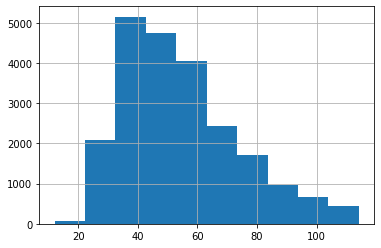

In [15]:
# общая площадь
data['total_area'].hist()

<AxesSubplot:>

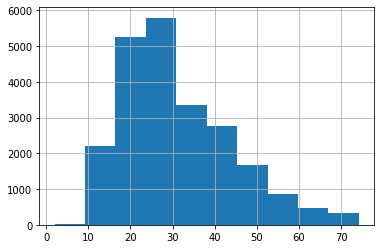

In [16]:
# жилая площадь
data['living_area'].hist()

<AxesSubplot:>

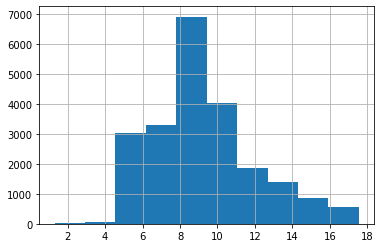

In [17]:
# площадь кухни
data['kitchen_area'].hist()

<AxesSubplot:>

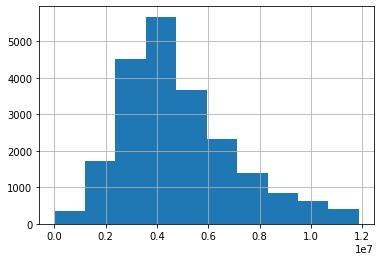

In [18]:
# цена объекта
data['last_price'].hist()

<AxesSubplot:>

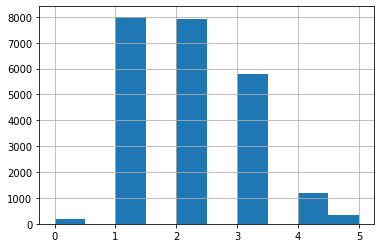

In [19]:
# количество комнат
data['rooms'].hist()

<AxesSubplot:>

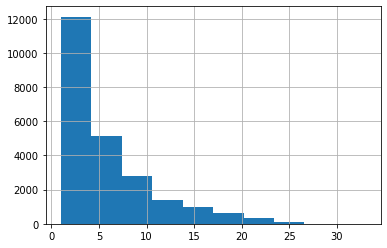

In [20]:
# этаж квартиры
data['floor'].hist()

<AxesSubplot:>

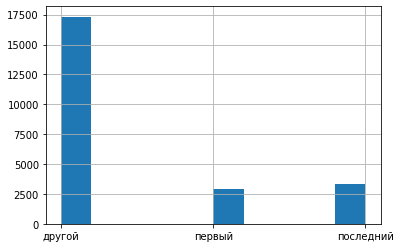

In [21]:
# тип этажа квартиры («первый», «последний», «другой»)
data['floor_type'].hist()

<AxesSubplot:>

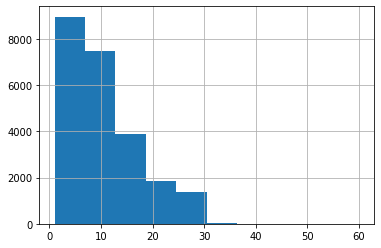

In [22]:
# общее количество этажей в доме
data['floors_total'].hist()

<AxesSubplot:>

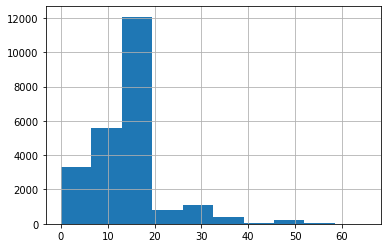

In [23]:
# расстояние до центра города в километрах
data['cityCenters_nearest'].hist()

<AxesSubplot:>

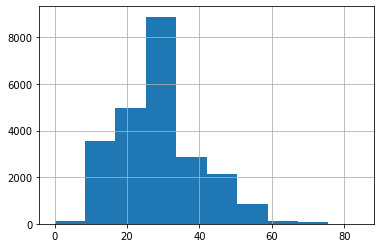

In [24]:
# расстояние до ближайшего аэропорта
data['airports_nearest'].hist()

<AxesSubplot:>

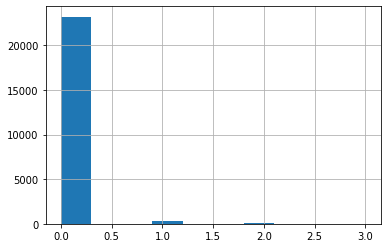

In [25]:
# расстояние до ближайшего парка
data['parks_nearest'].hist()

<AxesSubplot:>

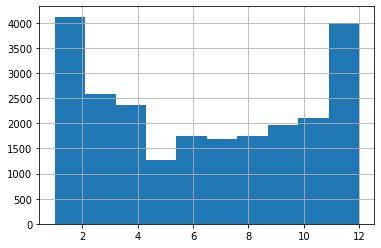

In [26]:
# месяц публикации объявления
data['month'].hist()

<AxesSubplot:>

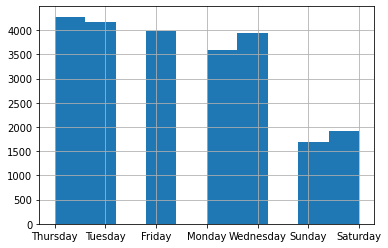

In [27]:
# день публикации объявления
data['weekday'].hist()

**Промежутчоные выводы**
По графикам можно сделаь выводы, что большинство квартир:
1. Общей площадью до 100 м.кв.
2. Жилая площадь у них до 50 м.кв.
3. Площадь кухни - 10 м.кв
4. Цена объекта - 
5. В соновнмо продаются 2х и 3х комнатные квартиры
6. на этажах от 1 до 3 
7. Предыдущий вывод подтверждается тем, что большинство квартир имеют тип этажа - "другой"
8. В основнмо продаются в домах с этажами от 1 до 5
9. До центра города у большинства квартир 12 км
10. До аэропорта 30 км
11. В большинстве квартир до ближайшего парка расстояние составит 0,5 км
12. Больше всего объявлений публикуется в январе и декабре
13. По дням недели: в будни дни объявления публикуются чаще чем в выходные

**Задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.**

count    21228.000000
mean       112.794564
std         96.371987
min          1.000000
25%         45.000000
50%         95.000000
75%        146.000000
max        427.000000
Name: days_exposition, dtype: float64
Среднее: 112.79456378368192
Медиана: 95.0


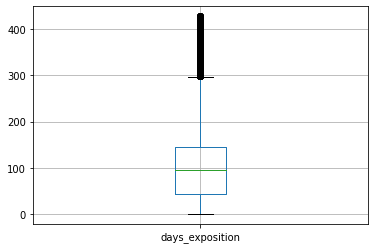

In [28]:
#строим гситограмму
print(data['days_exposition'].describe())
data.boxplot('days_exposition')
print('Среднее:', data['days_exposition'].mean())
print('Медиана:', data['days_exposition'].median())

**Вывод**
большинство квартир продаётся за 100 дней, это следует из графика (пиковое значение)
Быстрой продажей квартиры считаются продажи за 45 и меньше дней, долгой продажей наоборот - 146 и более дней.

**Задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."**

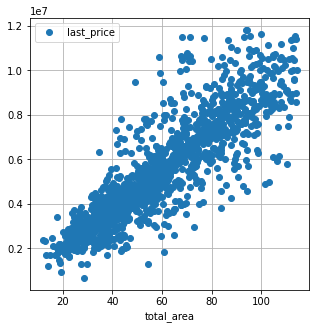

Корреляция цены: 

            last_price  total_area
last_price    1.000000    0.905372
total_area    0.905372    1.000000 



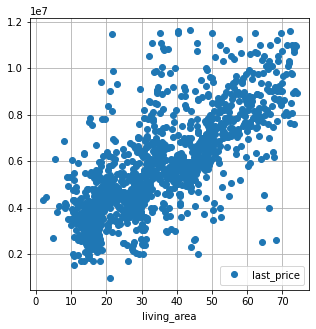

Корреляция цены: 

             last_price  living_area
last_price      1.00000      0.73747
living_area     0.73747      1.00000 



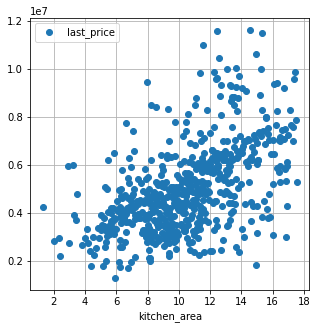

Корреляция цены: 

              kitchen_area  last_price
kitchen_area        1.0000      0.7999
last_price          0.7999      1.0000 



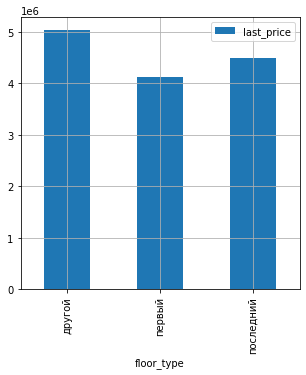

Корреляция цены: 

            last_price
last_price         1.0 



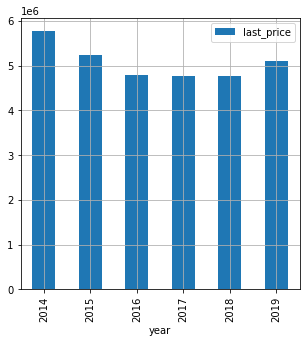

Корреляция цены: 

            last_price      year
last_price    1.000000  0.073543
year          0.073543  1.000000 



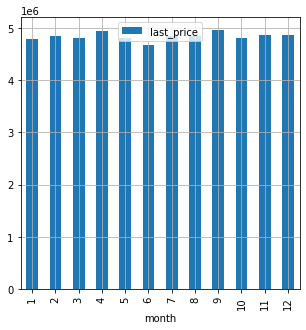

Корреляция цены: 

            last_price     month
last_price    1.000000  0.031709
month         0.031709  1.000000 



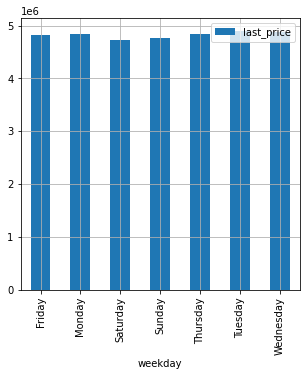

Корреляция цены: 

            last_price
last_price         1.0 



In [29]:
import matplotlib.pyplot as plt

# Зависимость цены от общей площади
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n')

# Зависимость цены жилой площади
(
    data.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['living_area', 'last_price']).corr(),'\n')

# Зависимость цены от площади кухни
(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr(),'\n')

# Зависимость цены от типа этажа, на котором расположена квартира (первый, последний, другой)
(
    data.pivot_table(index='floor_type', values='last_price')
    .plot(grid=True, kind='bar', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['floor_type', 'last_price']).corr(),'\n')

# Зависимость цены от даты размещения (день недели, месяц, год)
#год
(
    data.pivot_table(index='year', values='last_price')
    .plot(grid=True, kind='bar', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['year', 'last_price']).corr(),'\n')

#месяц
(
    data.pivot_table(index='month', values='last_price')
    .plot(grid=True, kind='bar', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['month', 'last_price']).corr(),'\n')

#день недели
(
    data.pivot_table(index='weekday', values='last_price')
    .plot(grid=True, kind='bar', figsize=(5, 5))
)
plt.show()
print('Корреляция цены:','\n')
print(data.pivot_table(index='floor', values=['weekday', 'last_price']).corr(),'\n')

**Выводы**
Исходя из графиков можно сделать следующие выводы:
1. Цена зависит от общей площади квартиры, чем больше площадь, тем больше цена (показатель корреляции 0,9)
2. Такая же зависимость прсолеживается и с жилой площадью, но менее ярко выраженная (кореляция 0,7)
3. От площади кухни цена зависит меньше чем от дилой и общей площади (кореляция 0,7)
4. От этажа цена также зависит, меньше всего на первом этаже, самая большая в категории "другие" (кореляция 1)
5. в 2014 году была самая большая стоимость квартиры, дальше стоимость опускалась, а в 2019 снова наблюдается рост. (кореляция 0,7)
6. По месяцам - показатели примерно равные, зависимости почти нет (кореляция 0,3)
7. По дням недели показатели прмиерно равны

**Задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."**

In [30]:
#Сначала выделим 10 населённых пунктов с наибольшим количеством объявлений
city = data['locality_name'].value_counts().head(10)
print(city)

# теперь посчитаем цену квадратного метра в каждом из городов
price_in_city = data.query('locality_name in (@city.index)').pivot_table(values='price_m2', index='locality_name')
price_in_city = price_in_city.astype(int)
price_in_city.sort_values('price_m2', ascending=False)

санкт-петербург      15651
поселок мурино         552
поселок шушары         439
всеволожск             398
пушкин                 369
колпино                338
поселок парголово      327
гатчина                307
деревня кудрово        299
выборг                 237
Name: locality_name, dtype: int64


,price_m2
locality_name,
санкт-петербург,103943
пушкин,99770
деревня кудрово,92410
поселок парголово,90339
поселок мурино,85629
поселок шушары,78674
колпино,75377
гатчина,68977
всеволожск,67478


**Выводы**
Самый дорогой квадратный метр в СПб - 104 693 руб. за метр кв. самый дешёвый в Выборге - 58 278 руб. за метр кв. Это логично, т.к.в пригороде жильё всё же дешевле

**Задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."**

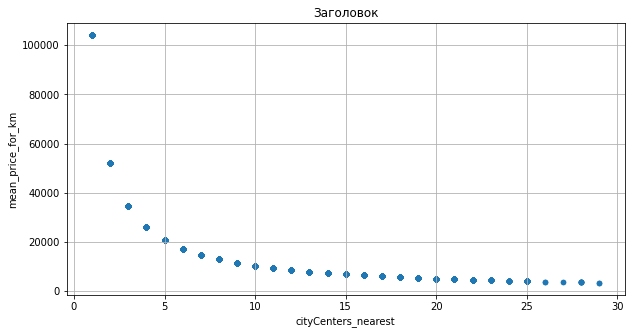

In [31]:
import matplotlib.pyplot as plt

# выбираем квартиры в спб
spb = data.query('locality_name == "санкт-петербург"')
#print(spb)
spb_mean = spb['price_m2'].mean()
pd.options.mode.chained_assignment = None
#print(spb_mean)

spb['mean_price_for_km'] = spb_mean / spb['cityCenters_nearest'] #средняя цена для каждого км
spb.plot(x='cityCenters_nearest', y='mean_price_for_km', kind='scatter', figsize=(10, 5), grid=True, title = 'Заголовок')
plt.show()

**Выводы**
Чем дальше от центра, тем выше цена кв. метра. тут тоже всё логично, тем ближе к центру, тем выше цена (например, практически в центре стоимость метра квадратного около 600 тыс. руб. в то время, как уже в 10 кс она ниже 100 тыс. руб.)

### Общий вывод

Была првоедена следующая работа с данными в результате которой убраны аномальные значения,леквидирвоаны пропуски, убраны дубликаты, т.к. они могли повлиять  на расчёты и конечные выводы. В последствии по данным првоедены расчёты и построены графики дял того чтобы понять зависимость цены от таких факторов как общая площадь, площадь кухни, жилая площадь, расстояние до аэропорта, парка, водоёма и др.

В результате, исходя из проведённых иследвоаний и рассчётов, можно сделать следующие выводы:
1. Самые дорогие квартиры в Санкт-Петербурге (средняя цена кв. метра 103 943 руб.)
2. Чем дальше город от Санкт-Петербурга, тем дешевле цена за метр кв. (например из топ 10 цен за метр квадратный самая дешёвая цена в Выборге - 59 535 руб. Это логично, т.к. он дальше остальных городов - 121 км)
3. Больше всего цена зависит от общей площади помещения (самая дорогая квартира больше 1 мл и с площадью больше 100 кв метров, а самая дешёвая стоит меньше 1 мл и по площади меньше 200 кв. метров)
4. От кухни и жилой площади цена зависит в меньшей степени.
5. также цена зависит от этажа. - на последнем эатже согласно графику цена самая большая
6. По месяцам чаще всего за максимальную цену продают в декабре, по годам, с 2014 ого цена падает
7. чаще всего квартиры продаются за 100 дней

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x] файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод